# Extended Wigner's friend scenario

An adapted notebook from Will pertaining to the extended Wigner's friend scenario.

This notebook is intended to run a benchmark to show a local friendliness violation from an extended Wigner's Friend scenario running on a QPU. For our friends we will use a GHZ state of increasing size. First we run on a simulator, then a noisy simulator, then on a real QPU.

Relevant References:
- [1]: ["A strong no-go theorem on the Wigner's friend paradox"](https://arxiv.org/abs/1907.05607)

- [2]: ["A scalable tripartite Wigner's friend scenario"](https://arxiv.org/abs/2109.02298)

- [3]: ["Thought experiments in a quantum computer"](https://arxiv.org/abs/2209.06236)

## Imports

In [55]:
import numpy as np
import itertools
import random
from enum import Enum

import qiskit
import qiskit.providers.aer.noise as noise
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.providers import Backend
from qiskit_aer.noise import NoiseModel

## Constants

In [56]:
BACKEND = qiskit.Aer.get_backend("aer_simulator")

# Create an empty noise model
NOISE_MODEL = None

SHOTS = 100_000

In [57]:
# Settings for extended Wigner's friend scenario.
class Setting(Enum):
    PEEK = 1
    REVERSE_1 = 2
    REVERSE_2 = 3
PEEK = Setting.PEEK.value
REVERSE_1 = Setting.REVERSE_1.value
REVERSE_2 = Setting.REVERSE_2.value
SETTINGS = [PEEK, REVERSE_1, REVERSE_2]

In [58]:
# Observers for scenario are Alice and Bob.
class Observer(Enum):
    ALICE = 0
    BOB = 1
ALICE = Observer.ALICE.value
BOB = Observer.BOB.value
OBSERVERS = [ALICE, BOB]

In [59]:
# Alice and Bob share a bipartite system of equal size.
ALICE_SIZE = 1
BOB_SIZE = 1

# Size of the systems held by the "friends" (Charlie and Debbie).
CHARLIE_SIZE = 3
DEBBIE_SIZE = 3

# Size of the bipartite quantum system.
SYS_SIZE = ALICE_SIZE + BOB_SIZE

# Two output bits for Alice and Bob.
MEAS_SIZE = 2

# Size of entire circuit
CIRCUIT_SIZE = SYS_SIZE + CHARLIE_SIZE + DEBBIE_SIZE

# Ranges for Charlie and Debbie's qubits depending on the size of their systems:
CHARLIE_QUBITS = range(SYS_SIZE, (SYS_SIZE + CHARLIE_SIZE))
DEBBIE_QUBITS = range(SYS_SIZE + CHARLIE_SIZE, SYS_SIZE + (CHARLIE_SIZE + DEBBIE_SIZE))

# Angles and beta term used for Alice and Bob measurement operators from arXiv:1907.05607.
# Note that despite the fact that degrees are used, we need to convert this to radians.
ANGLES = {PEEK: np.deg2rad(168), REVERSE_1: np.deg2rad(0), REVERSE_2: np.deg2rad(118)}
BETA = np.deg2rad(175)

## Expectation values

In [174]:
def single_expect(observer: Observer, setting: Setting, results: dict, charlie_size: int, debbie_size: int):
    """Compute single expectation values for either Alice or Bob."""
    if observer is ALICE:
        ret = 0
        for settings in results.keys():
            if settings[ALICE] is setting:
                if setting == PEEK:
                    zero_la = '0' * charlie_size
                    one_la = '1' * charlie_size
                    zero_lb = '0' * debbie_size
                    one_lb = '1' * debbie_size
                    probs = results[settings]
                    # <A> = P(00) + P(01) - P(10) - P(11)
                    ret += (
                        probs.get(zero_la + "0", 0)
                        + probs.get(zero_la + "1", 0)
                        - probs.get(one_la + "0", 0)
                        - probs.get(one_la + "1", 0)
                        + probs.get(zero_la + zero_lb, 0)
                        + probs.get(zero_la + one_lb, 0)
                        - probs.get(one_la + zero_lb, 0)
                        - probs.get(one_la + one_lb, 0)
                    )
                else:
                    zero_lb = '0' * debbie_size
                    one_lb = '1' * debbie_size
                    probs = results[settings]
                    # <A> = P(00) + P(01) - P(10) - P(11)
                    ret += (
                        probs.get("00", 0)
                        + probs.get("01", 0)
                        - probs.get("10", 0)
                        - probs.get("11", 0)
                        + probs.get("0" + zero_lb, 0)
                        + probs.get("0" + one_lb, 0)
                        - probs.get("1" + zero_lb, 0)
                        - probs.get("1" + one_lb, 0)
                    )

        return ret / len(SETTINGS)
    else:
        ret = 0
        for settings in results.keys():
            if settings[BOB] is setting:
                if setting == PEEK:
                    zero_la = '0' * charlie_size
                    one_la = '1' * charlie_size
                    zero_lb = '0' * debbie_size
                    one_lb = '1' * debbie_size
                    probs = results[settings]
                    # <A> = P(00) - P(01) + P(10) - P(11)
                    ret += (
                        probs.get("0" + zero_lb, 0)
                        - probs.get("0" + one_lb, 0)
                        + probs.get("1" + zero_lb , 0)
                        - probs.get("1" + one_lb, 0)
                        + probs.get(zero_la + zero_lb, 0)
                        - probs.get(zero_la + one_lb, 0)
                        + probs.get(one_la + zero_lb, 0)
                        - probs.get(one_la + one_lb, 0)
                    )
                else:
                    zero_la = '0' * charlie_size
                    one_la = '1' * charlie_size
                    probs = results[settings]
                    # <A> = P(00) - P(01) + P(10) - P(11)
                    ret += (
                        probs.get("00", 0)
                        - probs.get("01", 0)
                        + probs.get("10", 0)
                        - probs.get("11", 0)
                        + probs.get(zero_la + "0", 0)
                        - probs.get(zero_la + "1", 0)
                        + probs.get(one_la + "0", 0)
                        - probs.get(one_la + "1", 0)
                    )
        return ret / len(SETTINGS)

In [175]:
def double_expect(settings: list[Setting], results: dict, charlie_size: int, debbie_size: int) -> float:
    """Expectation value of product of two operators."""
    probs = results[settings]
    if settings == (PEEK, REVERSE_1) or settings == (PEEK, REVERSE_2):
        # <AB> = P(00, 0) - P(00, 1) - P(11, 0) + P(11, 1) for logical qubit of size 2 of ALICE
        zero_l = '0' * charlie_size
        one_l = '1' * charlie_size
        return (
            probs.get(zero_l + "0", 0) 
            - probs.get(zero_l + "1", 0) 
            - probs.get(one_l + "0", 0) 
            + probs.get(one_l + "1", 0)
        )    
    elif settings == (REVERSE_1, PEEK) or settings == (REVERSE_2, PEEK):
        # <AB> = P(0,00) - P(0, 11) - P(1, 00) + P(1, 11) for logical qubit of size 2 of BOB
        zero_l = '0' * debbie_size
        one_l = '1' * debbie_size
        return (
            probs.get("0" + zero_l, 0) 
            - probs.get("0" + one_l, 0) 
            - probs.get("1" + zero_l, 0) 
            + probs.get("1" + one_l, 0)
        ) 
    elif settings == (PEEK, PEEK):
        # <AB> = P(00, 00) - P(00, 11) - P(11, 00) + P(11, 11) for logical qubit of size 2 of ALICE and BOB
        zero_la = '0' * charlie_size
        one_la = '1' * charlie_size
        zero_lb = '0' * debbie_size
        one_lb = '1' * debbie_size
        return (
            probs.get(zero_la + zero_lb, 0) 
            - probs.get(zero_la + one_lb, 0) 
            - probs.get(one_la + zero_lb, 0) 
            + probs.get(one_la + one_lb, 0)
        ) 
    else:
        # <AB> = P(0, 0) - P(0, 1) - P(1, 0) + P(1, 1)
        return (
            probs.get("00", 0) 
            - probs.get("01", 0) 
            - probs.get("10", 0) 
            + probs.get("11", 0)
        ) 


## Consider all experimental settings

In [62]:
def generate_all_experiments(
    backend: Backend,
    noise_model: NoiseModel,
    shots: float,
    angles: list[float],
    beta: float,
    charlie_size: int,
    debbie_size: int
) -> dict[tuple[Observer, Observer], list[float]]:
    """Generate probabilitites for all combinations of experimental settings."""
    all_experiment_combos = list(itertools.product(SETTINGS, repeat=2))
    
    results = {}
    for alice, bob in all_experiment_combos:
        ewfs_circuit = ewfs(alice, bob, angles, beta, charlie_size, debbie_size)

        job = qiskit.execute(
            experiments=ewfs_circuit,
            backend=backend,
            noise_model=noise_model,
            basis_gates=noise_model.basis_gates if noise_model is not None else None,
            shots=shots,
        )
        counts = job.result().get_counts()
        
        # Convert counts to probabilities.
        probabilities = {key[::-1]: value / shots for key, value in counts.items()} #farrokh: I think that for some reason qiskit reverses the order of the bitstring key, so I reverse it again key[::-1]

        results[(alice, bob)] = probabilities
    return results

## State preparation

In [63]:
def prepare_bipartite_system(qc: QuantumCircuit):
    """Generates the state: 1/sqrt(2) * (|01> - |10>)"""
    qc.x(ALICE)
    qc.x(BOB)
    qc.h(ALICE)
    qc.cx(ALICE, BOB)

Confirm that the state preparation circuit generates $|\psi\rangle = \frac{1}{\sqrt{2}}\left(|01\rangle - 10\rangle\right)$:

In [64]:
circuit = QuantumCircuit(2)
prepare_bipartite_system(circuit)
print(qiskit.Aer.get_backend("statevector_simulator").run(circuit).result().get_counts())

{'01': 0.5, '10': 0.5}


## CNOT ladder circuit

In [65]:
def cnot_ladder(qc: QuantumCircuit, observer: Observer, friend_qubit: int, friend_size: int, reverse: bool, internal_copy: bool):
    """CNOT ladder circuit (GHZ without Hadamard)."""
    if internal_copy:
        if reverse:
            for i in range(friend_size-1):
                qc.cx(friend_qubit + friend_size-2-i, friend_qubit+friend_size-1-i)
            qc.cx(observer, friend_qubit)
        else:
            qc.cx(observer, friend_qubit)
            for i in range(friend_size-1):
                qc.cx(friend_qubit+i, friend_qubit + i + 1)
    else:
        if reverse:
            for i in range(friend_size):
                qc.cx(observer, friend_qubit+friend_size-1-i)
        else:
            for i in range(friend_size):
                qc.cx(observer, friend_qubit + i)

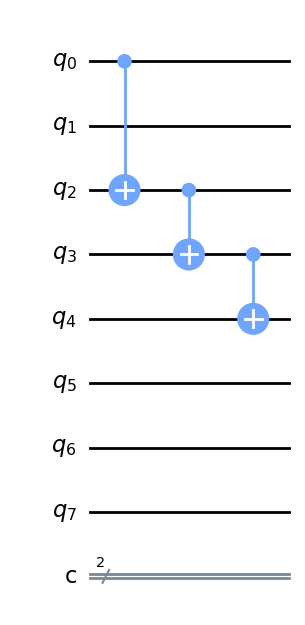

In [66]:
circuit = QuantumCircuit(CIRCUIT_SIZE, MEAS_SIZE)
cnot_ladder(circuit, ALICE, CHARLIE_QUBITS[0], CHARLIE_SIZE, reverse=False, internal_copy=True)
circuit.draw("mpl")

## Circuit for extended Wigner's friend scenario

In [67]:
def ewfs_rotation(qc: QuantumCircuit, qubit: int, angle: float):
    qc.rz(-angle, qubit)
    qc.h(qubit)
    
def apply_setting(qc: QuantumCircuit, 
                  observer: Observer, 
                  setting: Setting, 
                  angle: float, 
                  observer_creg: list[int] | int, 
                  charlie_size: int, 
                  debbie_size: int):
    """Apply either the PEEK or REVERSE_1/REVERSE_2 settings."""
    
    # Alice is the friend of Charlie and Bob is the friend of Debbie.
    charlie_qubits = range(SYS_SIZE, (SYS_SIZE + charlie_size))
    debbie_qubits = range(SYS_SIZE + charlie_size, SYS_SIZE + (charlie_size + debbie_size))
    friend_qubits = charlie_qubits if observer is ALICE else debbie_qubits
    friend_size = charlie_size if observer is ALICE else debbie_size
    
    if setting is PEEK:
        # The rotation gates should be applied to all qubits belonging to the friend.
        #for friend_qubit in friend_qubits:
        #    ewfs_rotation(qc, friend_qubit, angle)

        # Ask friend for the outcome. We pick a random qubit from friend's register.
        random_offset = random.randint(0, friend_size - 1)
        qc.measure(friend_qubits, observer_creg)
        #qc.measure(friend_qubits[0], observer)

    elif setting in [REVERSE_1, REVERSE_2]:
        cnot_ladder(qc, observer, friend_qubits[0], friend_size, reverse=True, internal_copy=True)

        # For either REVERSE_1 or REVERSE_2, apply the appropriate angle rotations.
        # Note that in this case, the rotation should occur on the observer's qubit.
        if observer is ALICE:
            qc.h(0)
            qc.rz(ANGLES[1], 0)        

        if observer is BOB:
            qc.h(1)        
            qc.rz((BETA - ANGLES[1]), 1)
        ewfs_rotation(qc, observer, angle)            
        qc.measure(observer, observer_creg)
        
def ewfs(alice_setting: Setting, 
        bob_setting: Setting, 
        angles: list[float], 
        beta: float,
        charlie_size: int,
        debbie_size: int) -> QuantumCircuit:
    """Generate the circuit for extended Wigner's friend scenario."""    
    # Define quantum registers
    alice, bob, charlie, debbie = [
        QuantumRegister(size, name=name) 
        for size, name in zip([ALICE_SIZE, BOB_SIZE, charlie_size, debbie_size], 
                              ["Alice", "Bob", "Charlie", "Debbie"])
    ]
    if alice_setting == PEEK and bob_setting == PEEK:
        measurement = ClassicalRegister(charlie_size + debbie_size, name="Measurement")
        alice_creg = list(range(charlie_size))
        bob_creg = list(range(charlie_size, charlie_size + debbie_size))
    elif (alice_setting == PEEK and bob_setting != PEEK):
        measurement = ClassicalRegister(charlie_size + 1, name="Measurement")
        alice_creg = list(range(charlie_size))
        bob_creg = charlie_size
    elif (alice_setting != PEEK and bob_setting == PEEK):
        measurement = ClassicalRegister(debbie_size + 1, name="Measurement")
        alice_creg = 0
        bob_creg = list(range(1, charlie_size + 1))
    else:
        measurement = ClassicalRegister(MEAS_SIZE, name="Measurement")
        alice_creg = 0
        bob_creg = 1
        
    
    # Create the Quantum Circuit with the defined registers
    qc = QuantumCircuit(alice, bob, charlie, debbie, measurement)

    charlie_qubits = range(SYS_SIZE, (SYS_SIZE + charlie_size))
    debbie_qubits = range(SYS_SIZE + charlie_size, SYS_SIZE + (charlie_size + debbie_size))
    
    # Prepare the bipartite quantum system
    prepare_bipartite_system(qc)
    qc.rz(-angles[1], 0)
    qc.h(0)
    
    qc.rz(-(beta - angles[1]), 1)
    qc.h(1)

    # Apply the CNOT ladder for Alice-Charlie and Bob-Debbie
    cnot_ladder(qc, ALICE, charlie_qubits[0], charlie_size, reverse=False, internal_copy=True)
    cnot_ladder(qc, BOB, debbie_qubits[0], debbie_size, reverse=False, internal_copy=True)

    # Apply the settings for Alice/Charlie and Bob/Debbie
    apply_setting(qc, ALICE, alice_setting, angles[alice_setting], alice_creg, charlie_size, debbie_size)
    apply_setting(qc, BOB, bob_setting, (beta - angles[bob_setting]), bob_creg, charlie_size, debbie_size)

    return qc

In [68]:
size = 1
qc = ewfs(1, 1, ANGLES, BETA, size, size)
#qc.draw("mpl")

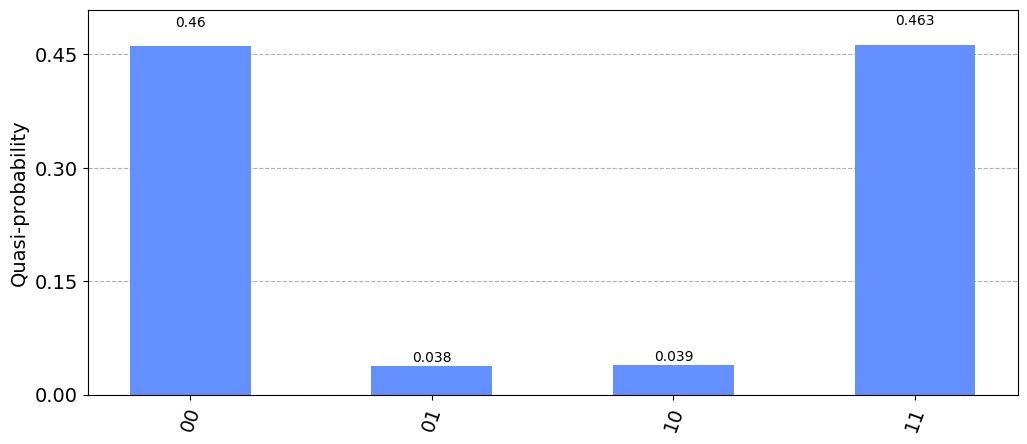

In [69]:
job = qiskit.execute(
    experiments=qc,
    backend=BACKEND,
    noise_model=noise_bit_flip,
    basis_gates=noise_bit_flip.basis_gates if noise_bit_flip is not None else None,
    shots=1e4,
)
counts = job.result().get_counts()

# Convert counts to probabilities.
probabilities = {key[::-1]: value / 1e4 for key, value in counts.items()}

from qiskit.visualization import plot_distribution
plot_distribution(probabilities, figsize=(12, 5))

In [70]:
probabilities

{'10': 0.0386, '01': 0.0379, '11': 0.463, '00': 0.4605}

In [71]:
setting_results

{'10': 0.0392, '01': 0.0421, '00': 0.4594, '11': 0.4593}

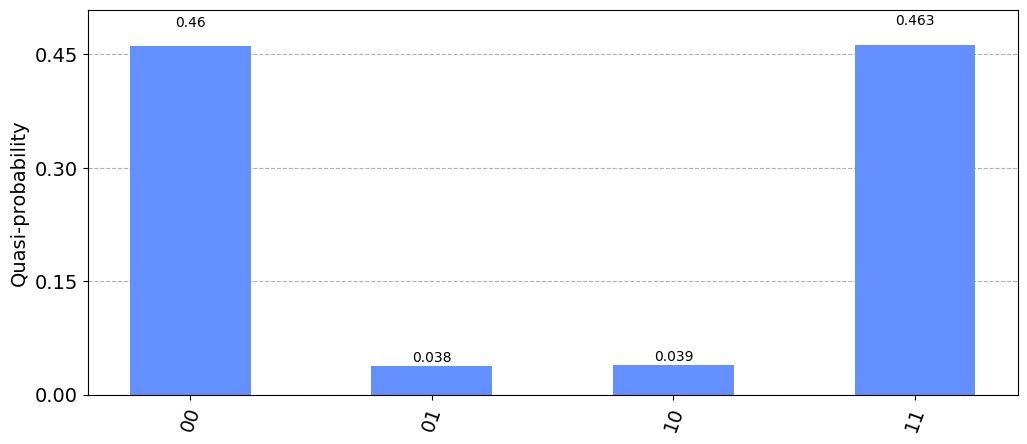

In [72]:
setting_results = {}
# Decode the keys for each measurement result of the setting.
for k, v in probabilities.items():
    alice_friend, bob_friend = k[:size], k[size:]

    alice_zero_count, bob_zero_count = alice_friend.count("0"), bob_friend.count("0")

    alice_decoding = "0" if alice_zero_count >= size // 2 + 1 else "1"
    bob_decoding = "0" if bob_zero_count >= size // 2 + 1 else "1"

    setting_results[alice_decoding + bob_decoding] = v

plot_distribution(setting_results, figsize=(12, 5))

## Inequalities

In [73]:
def compute_inequalities(results, charlie_size, debbie_size, verbose=False):
    A1 = single_expect(ALICE, PEEK, results, charlie_size=charlie_size, debbie_size=debbie_size)
    B1 = single_expect(BOB, PEEK, results, charlie_size=charlie_size, debbie_size=debbie_size)

    A2 = single_expect(ALICE, REVERSE_1, results, charlie_size=charlie_size, debbie_size=debbie_size)
    B2 = single_expect(BOB, REVERSE_1, results, charlie_size=charlie_size, debbie_size=debbie_size)

    A3 = single_expect(ALICE, REVERSE_2, results, charlie_size=charlie_size, debbie_size=debbie_size)
    B3 = single_expect(BOB, REVERSE_2, results, charlie_size=charlie_size, debbie_size=debbie_size)

    A1B1 = double_expect((PEEK, PEEK), results, charlie_size=charlie_size, debbie_size=debbie_size)
    A1B2 = double_expect((PEEK, REVERSE_1), results, charlie_size=charlie_size, debbie_size=debbie_size)
    A1B3 = double_expect((PEEK, REVERSE_2), results, charlie_size=charlie_size, debbie_size=debbie_size)

    A2B1 = double_expect((REVERSE_1, PEEK), results, charlie_size=charlie_size, debbie_size=debbie_size)
    A2B2 = double_expect((REVERSE_1, REVERSE_1), results, charlie_size=charlie_size, debbie_size=debbie_size)
    A2B3 = double_expect((REVERSE_1, REVERSE_2), results, charlie_size=charlie_size, debbie_size=debbie_size)

    A3B1 = double_expect((REVERSE_2, PEEK), results, charlie_size=charlie_size, debbie_size=debbie_size)
    A3B2 = double_expect((REVERSE_2, REVERSE_1), results, charlie_size=charlie_size, debbie_size=debbie_size)
    A3B3 = double_expect((REVERSE_2, REVERSE_2), results, charlie_size=charlie_size, debbie_size=debbie_size)
    
    # Local-friendliness inequalities:
    # Eq. (13) from [1].
    lf_1 = -A1 - A2 - B1 - B2 - A1B1 - 2*A1B2 - 2*A2B1 + 2*A2B2 - A2B3 - A3B2 - A3B3 - 6
    # Eq. (14) from [1].
    lf_2 = -A1 - A2 - A3 - B1 - A1B1 - A2B1 - A3B1 - 2*A1B2 + A2B2 + A3B2 - A2B3 + A3B3 - 5
    # Eq. (15) from [1].
    lf_3 = -A1 + A2 + B1 - B2 + A1B1 - A1B2 - A1B3 - A2B1 + A2B2 - A2B3 - A3B1 - A3B2 - 4 
    # Eq. (16) from [1].
    lf_4 = -A2 - A3 - B2 - B3 - A1B2 + A1B3 - A2B1 - A2B2 - A2B3 + A3B1 - A3B2 - A3B3 - 4

    # Brukner inequalities:
    # Eq. (17) from [1].
    brukner = A1B1 - A1B3 - A2B1 - A2B3 - 2
    # Eq. (18) from [1].
    semi_brukner = -A1B2 + A1B3 - A3B2 - A3B3 - 2

    # Positivity inequalities:
    # Eq. (19) from [1].
    pos_1 = 1 + A1 + B1 + A1B1
    # Eq. (20) from [1].
    pos_2 = 1 + A1 + B2 + A1B2
    # Eq. (21) from [1].
    pos_3 = 1 + A2 + B2 + A2B2

    # Bell non-LF 
    # Eq. (22) from [1].
    bell_non_lf = A2B2 - A2B3 - A3B2 - A3B3 - 2
    
    if verbose:
        print("******Inequalities******")
        print(f"{semi_brukner=} -- is violated: {semi_brukner > 0}")
        print(f"{brukner=} -- is violated: {brukner > 0}")
        print(f"{lf_1=} -- is violated: {lf_1 > 0}")
        print(f"{lf_2=} -- is violated: {lf_2 > 0}")
        print(f"{lf_3=} -- is_violated: {lf_3 > 0}")
        print(f"{lf_4=} -- is_violated: {lf_4 > 0}")
        print(f"{bell_non_lf=} -- is_violated: {bell_non_lf > 0}")
        print("**************************")
        
        print("******Expectation values******")
        print(f"{A1=}")
        print(f"{A2=}")
        print(f"{A3=}")
        print(f"{B1=}")
        print(f"{B2=}")
        print(f"{B3=}")
        print(f"{A1B1=}")
        print(f"{A1B2=}")
        print(f"{A1B3=}")
        print(f"{A2B1=}")
        print(f"{A2B2=}")
        print(f"{A2B3=}")
        print(f"{A3B1=}")
        print(f"{A3B2=}")
        print(f"{A3B3=}")
        print("******************************")
    return semi_brukner

In [184]:
noise_bit_flip = bitflip_model(0.01)

In [177]:
semi_brukner_results=[]
for size in range(1,6):
    results = generate_all_experiments(backend=BACKEND, noise_model=noise_bit_flip, shots=SHOTS, angles=ANGLES, beta=BETA, charlie_size=size, debbie_size=size)
    semi_brukner = compute_inequalities(results, charlie_size=size, debbie_size=size, verbose=False)
    semi_brukner_results.append(semi_brukner)

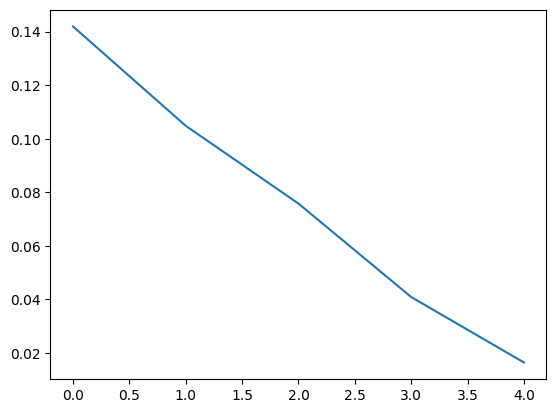

In [178]:
#this is without decoding
import matplotlib.pyplot as plt
plt.plot(semi_brukner_results)

In [185]:
semi_brukner_decoded_results=[]
for size in range(1,6):
    results = generate_all_experiments(backend=BACKEND, noise_model=noise_bit_flip, shots=SHOTS, angles=ANGLES, beta=BETA, charlie_size=size, debbie_size=size)
    semi_brukner_decoded = compute_inequalities(decode_results(results, charlie_size=size, debbie_size=size), charlie_size=1, debbie_size=1, verbose=False)
    semi_brukner_decoded_results.append(semi_brukner_decoded)

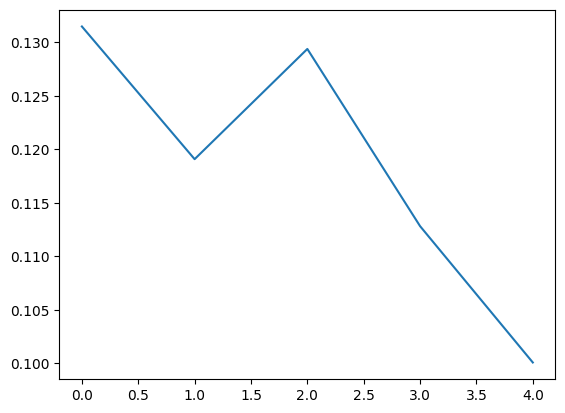

In [186]:
#this is with decoding
import matplotlib.pyplot as plt
plt.plot(semi_brukner_decoded_results)

In [183]:
noise_bit_flip = bitflip_model(0.01)
size=2
results = generate_all_experiments(backend=BACKEND, noise_model=noise_bit_flip, shots=SHOTS, angles=ANGLES, beta=BETA, charlie_size=size, debbie_size=size)
compute_inequalities(decode_results(results, charlie_size=size, debbie_size=size), charlie_size=1, debbie_size=1, verbose=True)

******Inequalities******
semi_brukner=0.10874000000000006 -- is violated: True
brukner=-0.13149999999999995 -- is violated: False
lf_1=0.025299999999999656 -- is violated: True
lf_2=-2.8952533333333332 -- is violated: False
lf_3=-0.15549999999999953 -- is_violated: False
lf_4=-1.1097333333333332 -- is_violated: False
bell_non_lf=0.3290000000000002 -- is_violated: True
**************************
******Expectation values******
A1=-0.03815333333333333
A2=0.0008199999999999897
A3=-0.001453333333333362
B1=-0.03734000000000004
B2=0.0008333333333333202
B3=0.001233333333333313
A1B1=0.8115600000000001
A1B2=-0.8787400000000001
A1B3=0.3272600000000001
A2B1=-0.8781599999999999
A2B2=0.92022
A2B3=-0.50604
A3B1=0.31898000000000004
A3B2=-0.49522000000000005
A3B3=-0.40751999999999994
******************************


0.10874000000000006

In [154]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.providers.aer import AerSimulator
from qiskit.tools.visualization import plot_histogram

# Import from Qiskit Aer noise module
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error


def bitflip_model(p):
    # Example error probabilities
    p_meas = p
    p_gate1 = p

    # QuantumError objects
    error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
    error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
    error_gate2 = error_gate1.tensor(error_gate1)

    # Add errors to noise model
    noise_bit_flip = NoiseModel()
    noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
    noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
    noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

    return noise_bit_flip

In [155]:
results

{(1, 1): {'0011': 0.0132, '1100': 0.01333, '0000': 0.48673, '1111': 0.48674},
 (1, 2): {'111': 0.00177, '001': 0.4975, '000': 0.002, '110': 0.49873},
 (1, 3): {'001': 0.15966, '111': 0.34376, '000': 0.33598, '110': 0.1606},
 (2, 1): {'111': 0.00167, '000': 0.00179, '011': 0.50142, '100': 0.49512},
 (2, 2): {'10': 0.001, '01': 0.00096, '11': 0.49868, '00': 0.49936},
 (2, 3): {'11': 0.11395, '01': 0.38728, '00': 0.11286, '10': 0.38591},
 (3, 1): {'100': 0.1614, '000': 0.33737, '011': 0.15976, '111': 0.34147},
 (3, 2): {'10': 0.38793, '01': 0.38545, '11': 0.11272, '00': 0.1139},
 (3, 3): {'11': 0.12766, '01': 0.37311, '00': 0.13068, '10': 0.36855}}

In [156]:
decode_results(results, charlie_size=size, debbie_size=size)

00 11
0 1
11 00
1 0
00 00
0 0
11 11
1 1
11 1
1 1
00 1
0 1
00 0
0 0
11 0
1 0
00 1
0 1
11 1
1 1
00 0
0 0
11 0
1 0
1 11
1 1
0 00
0 0
0 11
0 1
1 00
1 0
1 00
1 0
0 00
0 0
0 11
0 1
1 11
1 1


{(1, 1): {'01': 0.0132, '10': 0.01333, '00': 0.48673, '11': 0.48674},
 (1, 2): {'11': 0.00177, '01': 0.4975, '00': 0.002, '10': 0.49873},
 (1, 3): {'01': 0.15966, '11': 0.34376, '00': 0.33598, '10': 0.1606},
 (2, 1): {'11': 0.00167, '00': 0.00179, '01': 0.50142, '10': 0.49512},
 (2, 2): {'10': 0.001, '01': 0.00096, '11': 0.49868, '00': 0.49936},
 (2, 3): {'11': 0.11395, '01': 0.38728, '00': 0.11286, '10': 0.38591},
 (3, 1): {'10': 0.1614, '00': 0.33737, '01': 0.15976, '11': 0.34147},
 (3, 2): {'10': 0.38793, '01': 0.38545, '11': 0.11272, '00': 0.1139},
 (3, 3): {'11': 0.12766, '01': 0.37311, '00': 0.13068, '10': 0.36855}}

In [157]:
res = {(1, 2): {'111': 0.0018, '001': 0.4975, '000': 0.00164, '110': 0.49906}}
decode_results(res, charlie_size=size, debbie_size=size)

11 1
1 1
00 1
0 1
00 0
0 0
11 0
1 0


{(1, 2): {'11': 0.0018, '01': 0.4975, '00': 0.00164, '10': 0.49906}}

In [179]:
def decode_results(results: dict[str, float], charlie_size: int, debbie_size: int) -> dict[str, float]:
    """Take majority vote of measurement bit-strings."""
    decoded_results = {}
    # For each setting, there is a dictionary of measurement results.
    for setting in results:
        if setting == (PEEK, PEEK) or setting == (PEEK, REVERSE_1) or setting == (PEEK, REVERSE_2):
            setting_results = {}
            # Decode the keys for each measurement result of the setting.
            for k, v in results[setting].items():
                alice_friend, bob_friend = k[:charlie_size], k[debbie_size:]

                alice_zero_count, bob_zero_count = alice_friend.count("0"), bob_friend.count("0")
                if setting[1] == PEEK:
                    alice_decoding = "0" if alice_zero_count >= charlie_size // 2 + 1 else "1"
                    bob_decoding = "0" if bob_zero_count >= debbie_size // 2 + 1 else "1"
                else:
                    alice_decoding = "0" if alice_zero_count >= charlie_size // 2 + 1 else "1"
                    bob_decoding = "0" if bob_zero_count >= 1 else "1"


                if alice_decoding + bob_decoding in setting_results.keys():
                    setting_results[alice_decoding + bob_decoding] += v
                else:
                    setting_results[alice_decoding + bob_decoding] = v
            decoded_results[setting] = setting_results


        elif setting == (REVERSE_1, PEEK) or setting == (REVERSE_2, PEEK):
            setting_results = {}
            # Decode the keys for each measurement result of the setting.
            for k, v in results[setting].items():
                alice_friend, bob_friend = k[:1], k[1:]

                alice_zero_count, bob_zero_count = alice_friend.count("0"), bob_friend.count("0")

                alice_decoding = "0" if alice_zero_count >= 1 else "1"
                bob_decoding = "0" if bob_zero_count >= debbie_size // 2 + 1 else "1"

 
                if alice_decoding + bob_decoding in setting_results.keys():
                    setting_results[alice_decoding + bob_decoding] += v
                else:
                    setting_results[alice_decoding + bob_decoding] = v
            decoded_results[setting] = setting_results

        else:
            decoded_results[setting] = results[setting]
            
    return decoded_results

def single_expect(observer: Observer, setting: Setting, results: dict, charlie_size=1, debbie_size=1) -> dict[str, float]:
    """Compute single expectation values for either Alice or Bob."""
    if observer is ALICE:
        ret = 0
        for settings in results.keys():
            if settings[ALICE] is setting:
                probs = results[settings]
                # <A> = P(00) + P(01) - P(10) - P(11)
                ret += (
                    probs.get("00", 0)
                    + probs.get("01", 0)
                    - probs.get("10", 0)
                    - probs.get("11", 0)
                )
        return ret / len(SETTINGS)
    else:
        ret = 0
        for settings in results.keys():
            if settings[BOB] is setting:
                probs = results[settings]
                # <B> = P(00) - P(01) + P(10) - P(11)
                ret += (
                    probs.get("00", 0)
                    - probs.get("01", 0)
                    + probs.get("10", 0)
                    - probs.get("11", 0)
                )
        return ret / len(SETTINGS)


def double_expect(settings: list[Setting], results: dict, charlie_size=1, debbie_size=1) -> float:
    """Expectation value of product of two operators."""
    probs = results[settings]
    # <AB> = P(00) - P(01) - P(10) + P(11)
    return (
        probs.get("00", 0) 
        - probs.get("01", 0) 
        - probs.get("10", 0) 
        + probs.get("11", 0)
    )    


